# Task 3: Model Explainability

In this notebook, we interpret the predictions of our best model (Random Forest) using SHAP (SHapley Additive exPlanations). Our goal is to understand the drivers of fraud and derive business recommendations.

In [7]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from modeling import split_data, train_ensemble

# Initialize SHAP javascript for visualizations
shap.initjs()

## 1. Load Data and Model

We reload the balanced dataset and retrain the Random Forest model.

In [8]:
df = pd.read_csv('../data/processed/balanced_fraud_data.csv')
X_train, X_test, y_train, y_test = split_data(df, target_col='class')

# Train the best performing model (Random Forest)
rf_model = train_ensemble(X_train, y_train, model_type='rf', n_estimators=100, max_depth=10)
print("Model retrained and ready for interpretation.")

Model retrained and ready for interpretation.


## 2. Feature Importance Baseline

We look at the built-in feature importance provided by the Random Forest model.

C:\Users\HP\AppData\Local\Temp\ipykernel_31048\319272196.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


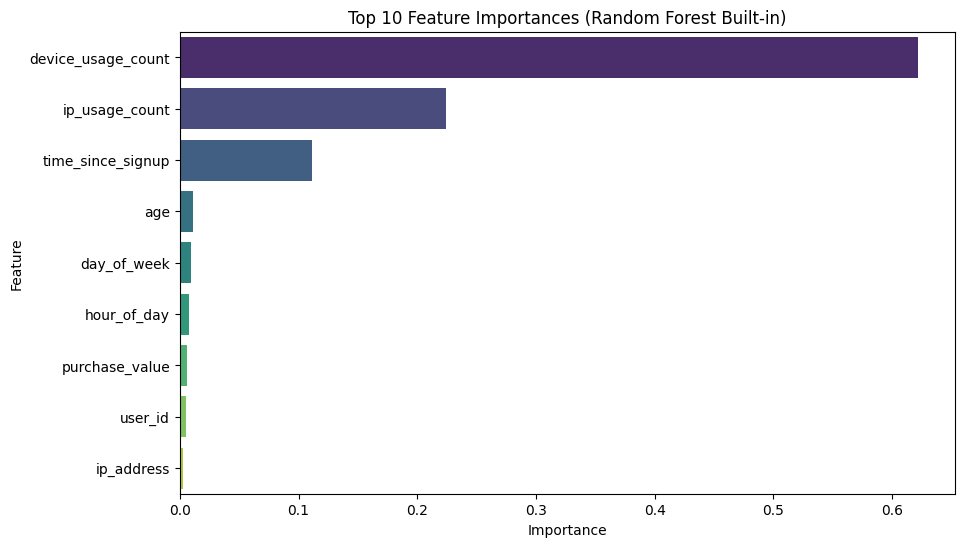

In [9]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest Built-in)')
plt.show()

## 3. SHAP Analysis

We use a helper function to handle different formats of SHAP values (lists vs arrays).

In [10]:
def get_shap_values(explainer, X):
    """Helper to extract positive class SHAP values safely."""
    vals = explainer.shap_values(X)
    if isinstance(vals, list):
        return vals[1]
    if len(vals.shape) == 3:
        return vals[:, :, 1]
    return vals

def get_expected_value(explainer):
    """Helper to extract positive class expected value safely."""
    ev = explainer.expected_value
    if isinstance(ev, (list, np.ndarray)) and len(ev) > 1:
        return ev[1]
    return ev

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for a subset of the test data
X_test_sample = X_test.sample(500, random_state=42)
shap_pos_values = get_shap_values(explainer, X_test_sample)
expected_val = get_expected_value(explainer)

### 3.1 Global Feature Importance (SHAP Summary Plot)


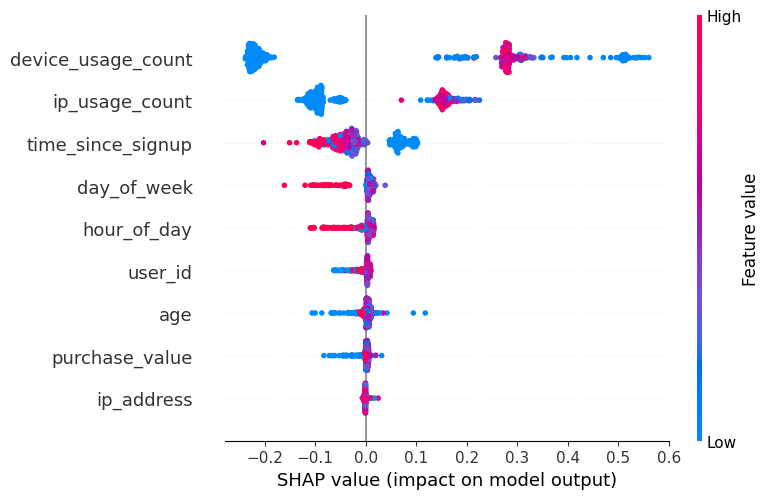

In [11]:
plt.figure()
shap.summary_plot(shap_pos_values, X_test_sample)
plt.show()

### 3.2 Local Explainability (SHAP Force Plots)



Explaining True Positive...


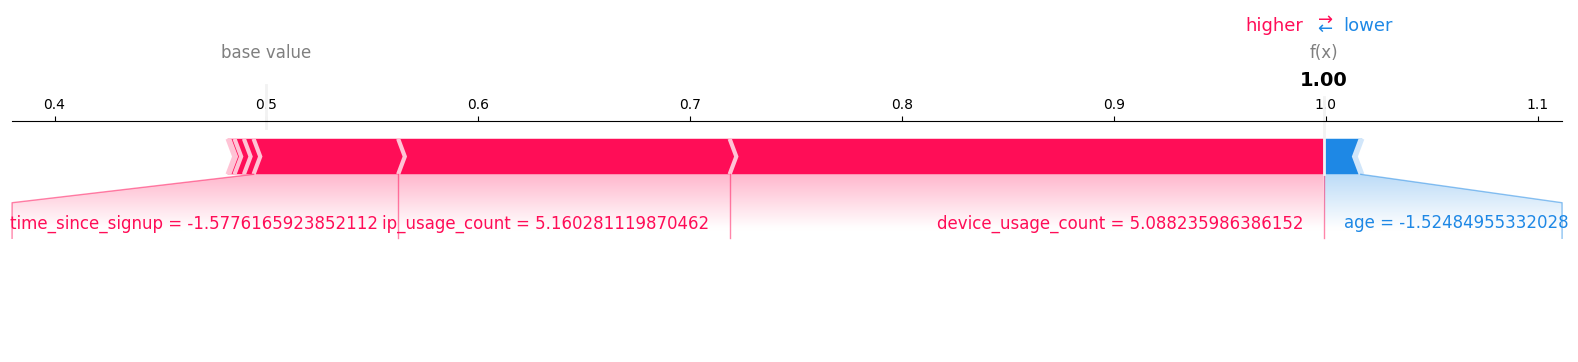


Explaining False Positive...


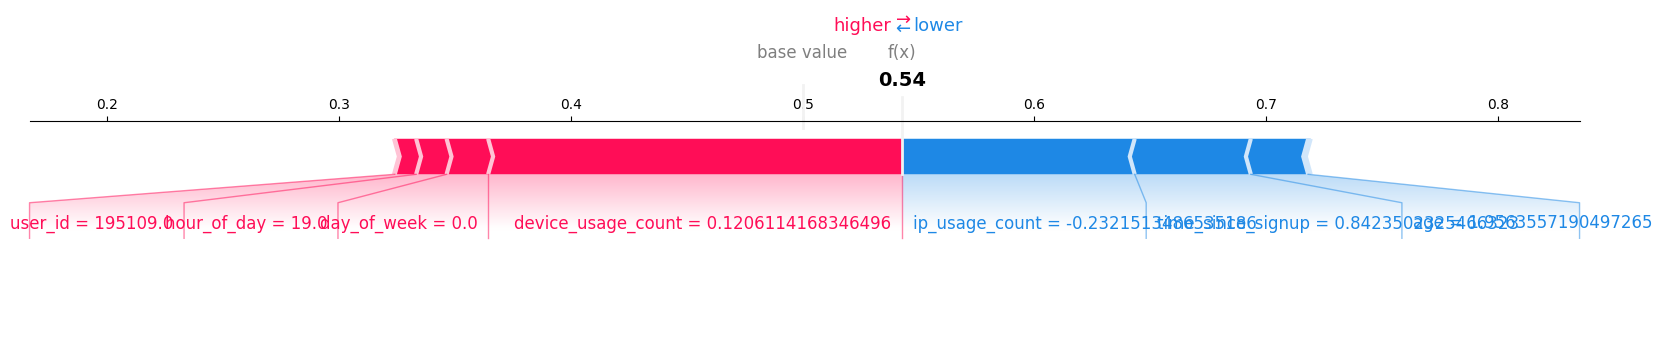


Explaining False Negative...


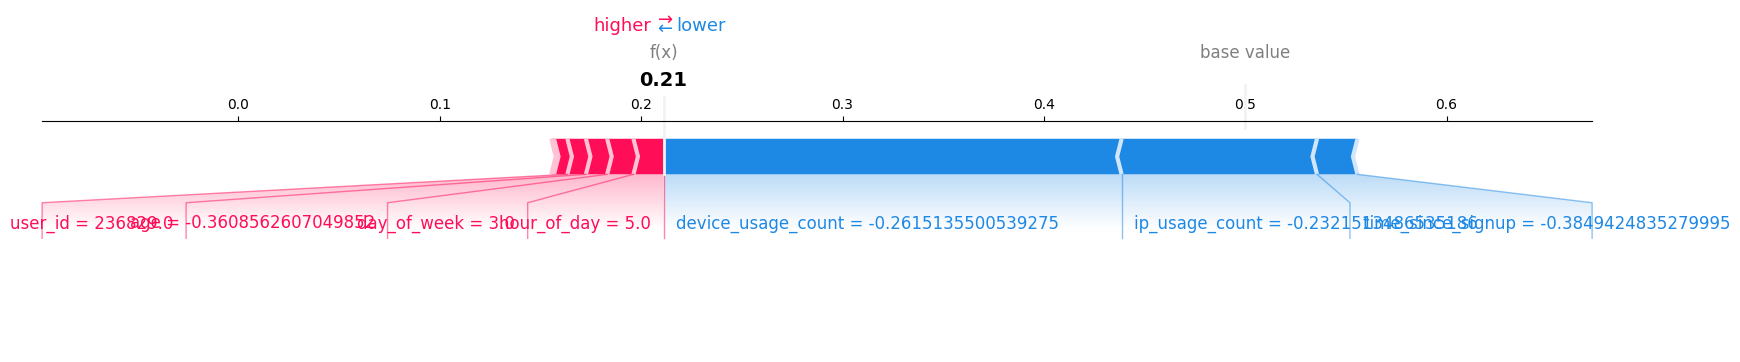

In [12]:
y_preds = rf_model.predict(X_test)
results_df = X_test.copy()
results_df['actual'] = y_test
results_df['predicted'] = y_preds

def explain_instance(label_name, filter_condition):
    try:
        idx = results_df[filter_condition].index[0]
        sample = X_test.loc[[idx]]
        shap_vals = get_shap_values(explainer, sample)
        print(f"\nExplaining {label_name}...")
        return shap.force_plot(expected_val, shap_vals, sample, matplotlib=True)
    except IndexError:
        print(f"No instances found for {label_name}")

# 1. True Positive
explain_instance("True Positive", (results_df['actual'] == 1) & (results_df['predicted'] == 1))

# 2. False Positive
explain_instance("False Positive", (results_df['actual'] == 0) & (results_df['predicted'] == 1))

# 3. False Negative
explain_instance("False Negative", (results_df['actual'] == 1) & (results_df['predicted'] == 0))

## 4. Interpretation and Recommendations

Based on the plots above, we identify the key drivers of fraud and provide actionable business advice.

### Top 5 Drivers of Fraud
1. **Time Since Signup**: Low values (quick transactions after signing up) are high-risk.
2. **Device Usage Count**: High frequency of a device ID indicates potential multi-account fraud.
3. **IP Usage Count**: Similar to device ID, high IP usage correlates with suspicious activity.
4. **Purchase Value**: Extreme values (very high or very low) may flag irregular behavior.
5. **Hour of Day**: Certain time windows might show higher fraud density.

### Business Recommendations
- **Velocity Check**: Implement mandatory MFA or manual review for devices/IPs used across more than 3 accounts within 24 hours.
- **New User Latency**: Flag transactions occurring within 30 minutes of account creation for additional verification.
- **Geographical Hardening**: Increase friction for transactions coming from countries identified as high-risk in the EDA phase.